<a href="https://colab.research.google.com/github/prateektrivedi21/Stress-Detection-from-text-stream/blob/main/Stress_Detection_from_text_stream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score
import seaborn as sns
import numpy as np
import string

In [4]:
#Load the dataset
df = pd.read_csv("stress.csv")
df.head()

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1521614353,5,1.806818,...,1.000,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1.0,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1527009817,4,9.429737,...,1.125,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2.0,8.828316,0.292857
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.8,1535935605,2,7.769821,...,1.000,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0.0,7.841667,0.011894
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,1,0.6,1516429555,0,2.667798,...,1.000,1.1250,1.0,1.75356,1.52114,1.98848,0.50,5.0,4.104027,0.141671
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1421,1,0.8,1539809005,24,7.554238,...,1.000,1.1250,1.0,1.77644,1.64872,1.81456,1.00,1.0,7.910952,-0.204167


### Data Cleaning

In [5]:
# Checking to see if the data contains any null values

df.isnull().sum()

subreddit                   0
post_id                     0
sentence_range              0
text                        0
id                          0
                           ..
lex_dal_avg_pleasantness    1
social_upvote_ratio         1
social_num_comments         1
syntax_fk_grade             1
sentiment                   1
Length: 116, dtype: int64

In [6]:
# Cleaning the text columns with stopwords, links, special symbols and language errors

nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")
stopword_set = set(stopwords.words('english'))

# Text cleaning function

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = ' '.join([word for word in text.split() if word not in stopword_set])
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

# Apply the cleaning function to the text column

df["text"] = df["text"].apply(clean)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


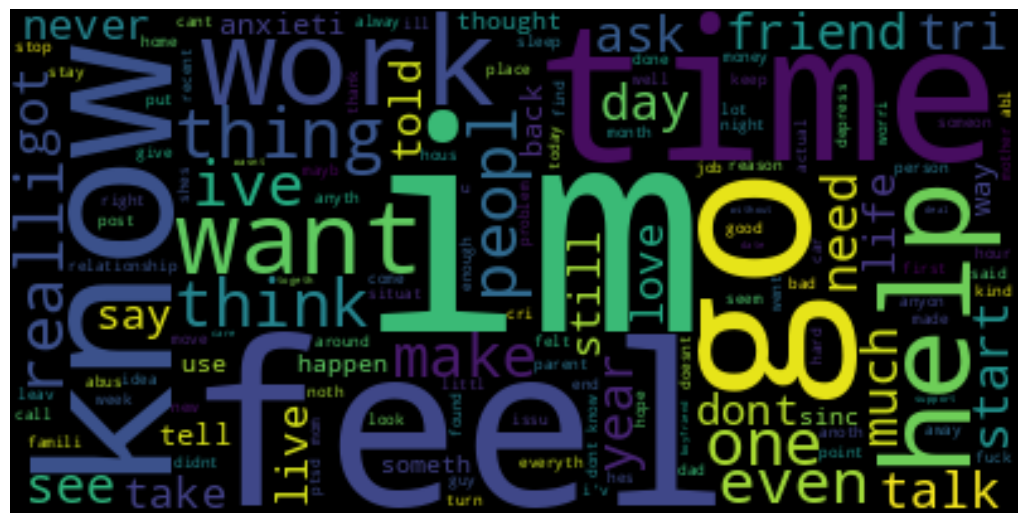

In [7]:
# Visualizing a word cloud of the text column

stopwords = set(STOPWORDS)
text = " ".join(i for i in df.text)
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="black").generate(text)

plt.figure(figsize=(13, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [8]:
# STRESS DETECTION MODEL
# In this dataset, I assign 0 as no stress
# and 1 as stress.

df["label"] = df["label"].map({0: "No Stress", 1: "Stress"})
df = df[["text", "label"]]
print(df.head())

                                                text      label
0  said felt way sugget go rest trigger ahead you...     Stress
1  hey rassist sure right place post goe im curre...  No Stress
2  mom hit newspap shock would know dont like pla...     Stress
3  met new boyfriend amaz kind sweet good student...     Stress
4  octob domest violenc awar month domest violenc...     Stress


In [9]:
# I will split the dataset into training and test sets

x = np.array(df["text"])
y = np.array(df["label"])

cv = CountVectorizer()
X = cv.fit_transform(x)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.30, random_state=50)

In [10]:
# As the task is based on the binary classification,
# I would use the Bernoulli Naive Bayes algorithm to
# train the detection model

model = BernoulliNB()
model.fit(xtrain, ytrain)
print(f"Accuracy of model on Training Data: {model.score(xtrain, ytrain)*100}")

Accuracy of model on Training Data: 93.13276651406149


In [11]:
# Make predictions

y_pred = model.predict(xtest)
y_prob = model.predict_proba(xtest)[:, 1]

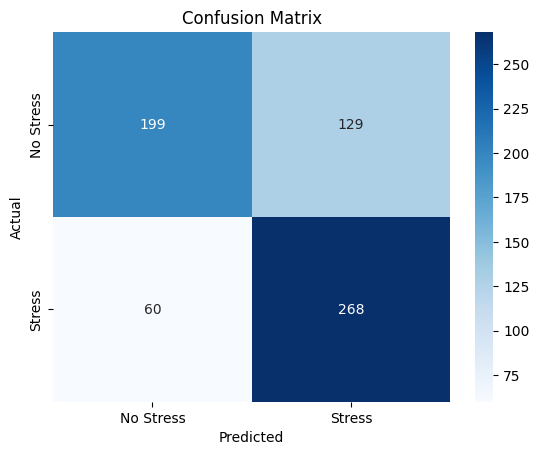

In [12]:
# Confusion Matrix

conf_mat = confusion_matrix(ytest, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stress', 'Stress'], yticklabels=['No Stress', 'Stress'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

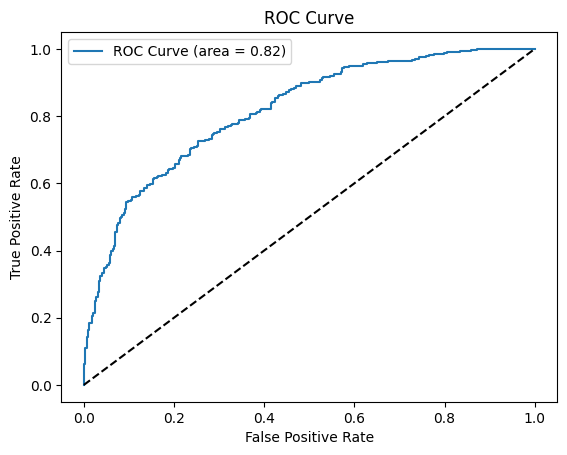

In [13]:
# ROC Curve

fpr, tpr, thresholds = roc_curve(ytest, y_prob, pos_label='Stress')
roc_auc = roc_auc_score(ytest, y_prob)
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [14]:
# Model Accuracy

accuracy = accuracy_score(ytest, y_pred)
print(f'Model Accuracy: {accuracy:.2f}')

Model Accuracy: 0.71


In [15]:
# Function for user input and prediction

def predict_stress(text):
    cleaned_text = clean(text)
    data = cv.transform([cleaned_text]).toarray()
    prediction = model.predict(data)
    return prediction[0]

In [16]:
# Let's test the performance of our model
# based on some random sentences on mental health

user_input = input("Enter a Text: ")
output = predict_stress(user_input)
print(f"Prediction: {output}")

Enter a Text: I am really worried as my exams are about to start
Prediction: Stress
